* Name: `dissipation-theory--Study-17.ipynb`
* Author: John A. Marohn
* Date: 2024-05-31
* Continued from: ---
* Continued to: ---
* Summary: Test drive the new BLDS code.

# Preliminaries

In [1]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation import blds_perpendicular_jit
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
THIS = 'dissipation-theory--Study-17'

# Setup cantilever and sample objects

Compute the mobility in m$^2$/vs

In [38]:
mu_guess = ureg.Quantity(4e-4,'cm^2/(V s)')
mu_guess.to('m^2/(V s)')

4e-08 <Unit('meter ** 2 / second / volt')>

In [54]:
sample1_jit = SampleModel1Jit(
    cantilever = CantileverModelJit(
        f_c = 75e3, 
        V_ts = 1.0,
        R = 60e-9,  # really think 30 nm
        d = 170e-9),  # 120 + 100/2 = 170  ; "100 to 200 nm pp"
    h_s = 120e-9, 
    epsilon_s = complex(3.4, 0),
    mu = mu_guess.to('m^2/(V s)').magnitude,
    rho = 1e21,
    epsilon_d = complex(1e6, 0),
    z_r = 300e-9
)

# Fix mobility, vary charge density

Set up an array of charge densities, in units of [1/m$^3$]

In [55]:
rho = np.array([1e15, 1e17, 1e19, 1e21, 1e23, 1e25, 1e27])
rho

array([1.e+15, 1.e+17, 1.e+19, 1.e+21, 1.e+23, 1.e+25, 1.e+27])

Set up an array of frequency points at which to compute the BLDS signal.

In [69]:
omega_m = ureg.Quantity(np.logspace(start=np.log10(1e2), stop=np.log10(3e6), num=25), 'Hz')
omega_m

Magnitude,[100.0 153.65500778173057 236.09861416403658 362.7773439663084 557.4255561017867 856.5122816055552 1316.0740129524927 2022.2136270154863 3107.232505953861 4774.418348819862 7336.132885411532 11272.335555957185 17320.508075688776 26613.82803153489 40893.47953287128 62834.8791584537 96548.93846056313 148352.2789047564 227950.70569547784 350257.6745748966 538188.4571241653 826953.515674511 1270655.4888609657 1952425.7902883014 3000000.000000001]
Units,hertz


In [70]:
data1 = {}
rho_original =  sample1_jit.rho
for rho_ in rho:
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')
    sample1_jit.rho = rho_
    for index, omega_ in enumerate(omega_m):
        freq[index] = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_).to('Hz')
    data1[str(rho_)] = {'x': omega_m, 'y': freq, 'rho': sample1_jit.rho, 'mu': sample1_jit.mu}
sample1_jit.rho = rho_original

In [97]:
sample1_jit.cantilever.R

6e-08

In [98]:
def plotme(data, sample_jit):

    for key in data.keys():
        
        plt.semilogx(
            data[key]['x'].to('Hz').magnitude,
            np.abs(data[key]['y'].to('Hz').magnitude),
            '-',
            label="{:0.1e}, {:0.1e}".format(data[key]['rho'],data[key]['mu']))

    lbl = '$d = $ {:0.1f} nm, $R = $ {:0.1f} nm'.format(sample_jit.cantilever.d/1e-9, sample_jit.cantilever.R/1e-9)
    plt.title(lbl, fontsize=9)
    plt.legend(title='$\\rho$ [1/m$^3$], $\\mu$ [m$^2$/Vs]', title_fontsize=9, fontsize=8)
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. frequency $\omega_{\mathrm{m}}$ [rad/s]')
    plt.show()

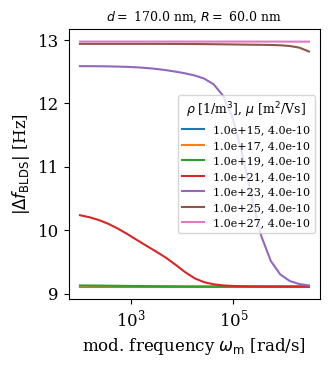

In [99]:
plotme(data1, sample1_jit)

# Fix charge density, vary mobility

Set up an array of mobilities, in units of m$^2$/Vs.

In [100]:
mu = np.array([4e-6, 4e-7, 4e-8, 4e-9, 4e-10])

In [101]:
data2 = {}
mu_original =  sample1_jit.mu
for mu_ in mu:
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')
    sample1_jit.mu = mu_
    for index, omega_ in enumerate(omega_m):
        freq[index] = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_).to('Hz')
    data2[str(mu_)] = {'x': omega_m, 'y': freq, 'rho': sample1_jit.rho, 'mu': sample1_jit.mu}
sample1_jit.mu = mu_original

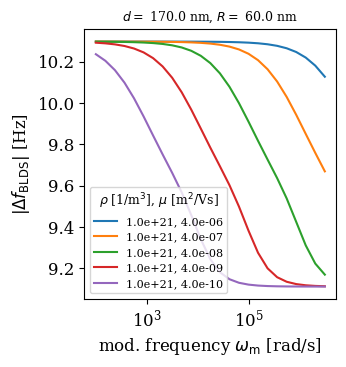

In [102]:
plotme(data2, sample1_jit)

# Change the height

In [105]:
data3 = {}
d_original = sample1_jit.cantilever.d
sample1_jit.cantilever.d = 90e-9
mu_original =  sample1_jit.mu
for mu_ in mu:
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')
    sample1_jit.mu = mu_
    for index, omega_ in enumerate(omega_m):
        freq[index] = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_).to('Hz')
    data3[str(mu_)] = {'x': omega_m, 'y': freq, 'rho': sample1_jit.rho, 'mu': sample1_jit.mu}

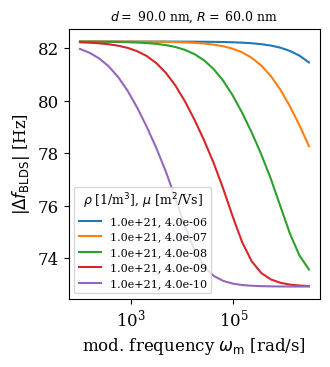

In [106]:
plotme(data3, sample1_jit)
sample1_jit.cantilever.d = d_original